In [1]:
%matplotlib widget
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import matplotlib.pyplot as plt
import initial_event_times as iet

import obspy.signal.trigger as trigger
# trigger.aic_simple

number of events detected: (2002, 6)


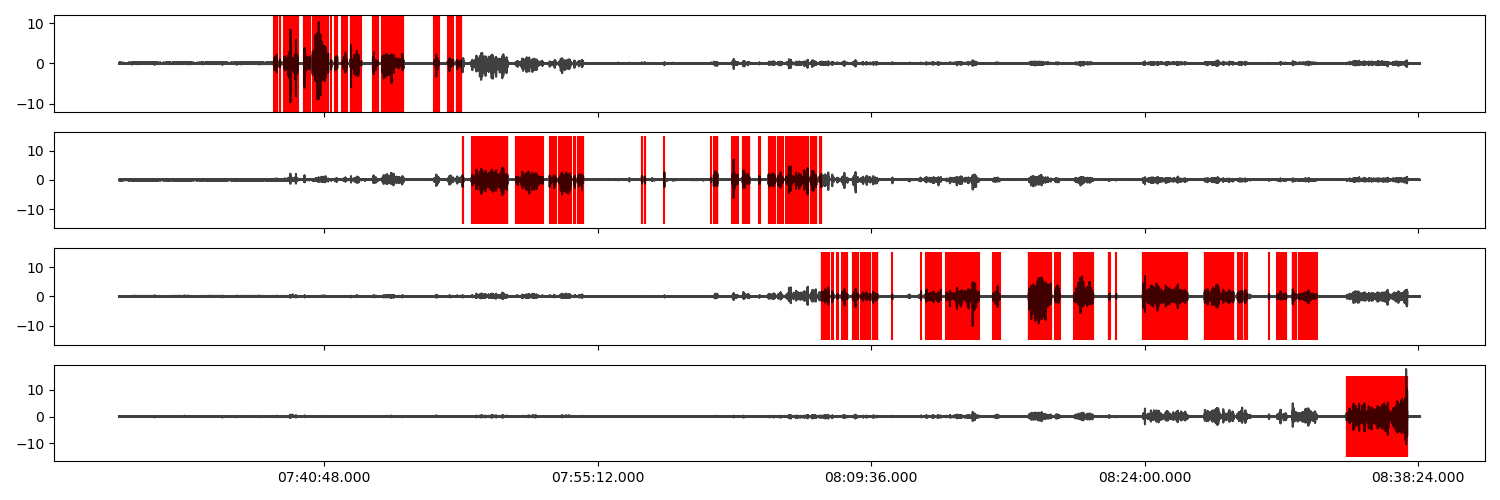

In [2]:
fig, axes = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

for n, ax in enumerate(axes):
    data = iet.day141_snapshot[n+2]
    ax.plot(data.times('matplotlib'), data.data, color='black', alpha=0.75)
    h_id = list(iet.detector_data.keys())[n]
    # ax.vlines(x=get_event_times('h3'), ymin=-15, ymax=15, color='red')
    ax.vlines(x=iet.get_event_times(h_id), ymin=-15, ymax=15, color='red')


axes[0].set_ylim(-12, 12)
axes[-1].xaxis.set_major_formatter(plotting.PrecisionDateFormatter("%H:%M:%S.{ms}"))
fig.tight_layout()

In [3]:
iet.df

,index,event_times (mpl),event_times (abs),hphone_idx,ones,event_times
0,0,18037.318174,2019-05-21T07:38:10.208000Z,h3,1,2019-05-21 07:38:10.208000+00:00
1,1,18037.318189,2019-05-21T07:38:11.526000Z,h3,1,2019-05-21 07:38:11.526000+00:00
2,2,18037.318203,2019-05-21T07:38:12.754000Z,h3,1,2019-05-21 07:38:12.754000+00:00
3,3,18037.318207,2019-05-21T07:38:13.074000Z,h3,1,2019-05-21 07:38:13.074000+00:00
4,4,18037.318219,2019-05-21T07:38:14.141000Z,h3,1,2019-05-21 07:38:14.141000+00:00
...,...,...,...,...,...,...
1997,300,18037.359564,2019-05-21T08:37:46.291000Z,h6,1,2019-05-21 08:37:46.291000+00:00
1998,301,18037.359570,2019-05-21T08:37:46.891000Z,h6,1,2019-05-21 08:37:46.891000+00:00
1999,302,18037.359578,2019-05-21T08:37:47.564000Z,h6,1,2019-05-21 08:37:47.564000+00:00
2000,303,18037.359589,2019-05-21T08:37:48.513000Z,h6,1,2019-05-21 08:37:48.513000+00:00


In [4]:
# event_id = 60
# hydrophone = 'h3'

# event_raw = iet.get_event_window_raw(iet.df['event_times (abs)'].iloc[event_id], hydrophone=hydrophone)

# fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

# t = event_raw.times()

# ax[1].plot(t, event_raw.data)

# # raw event aic
# aic = trigger.aic_simple(event_raw.data)
# aic_arrival = t[aic.argmin()]
# ax[0].plot(t, aic)
# ax[1].vlines(x=aic_arrival, ymin=-5, ymax=5, color='red', label='raw waveform aic')

# # filter 50hz
# event50hz = event_raw.copy().filter(type='highpass', zerophase=False, corners=1, freq=50)
# aic = trigger.aic_simple(event50hz.data)
# aic_arrival = t[aic.argmin()]
# ax[0].plot(t, aic)
# ax[1].vlines(x=aic_arrival, ymin=-5, ymax=5, color='green', label='50 hz aic')

# ax[1].legend(fontsize=15)
# fig.tight_layout()
# aic.argmin()

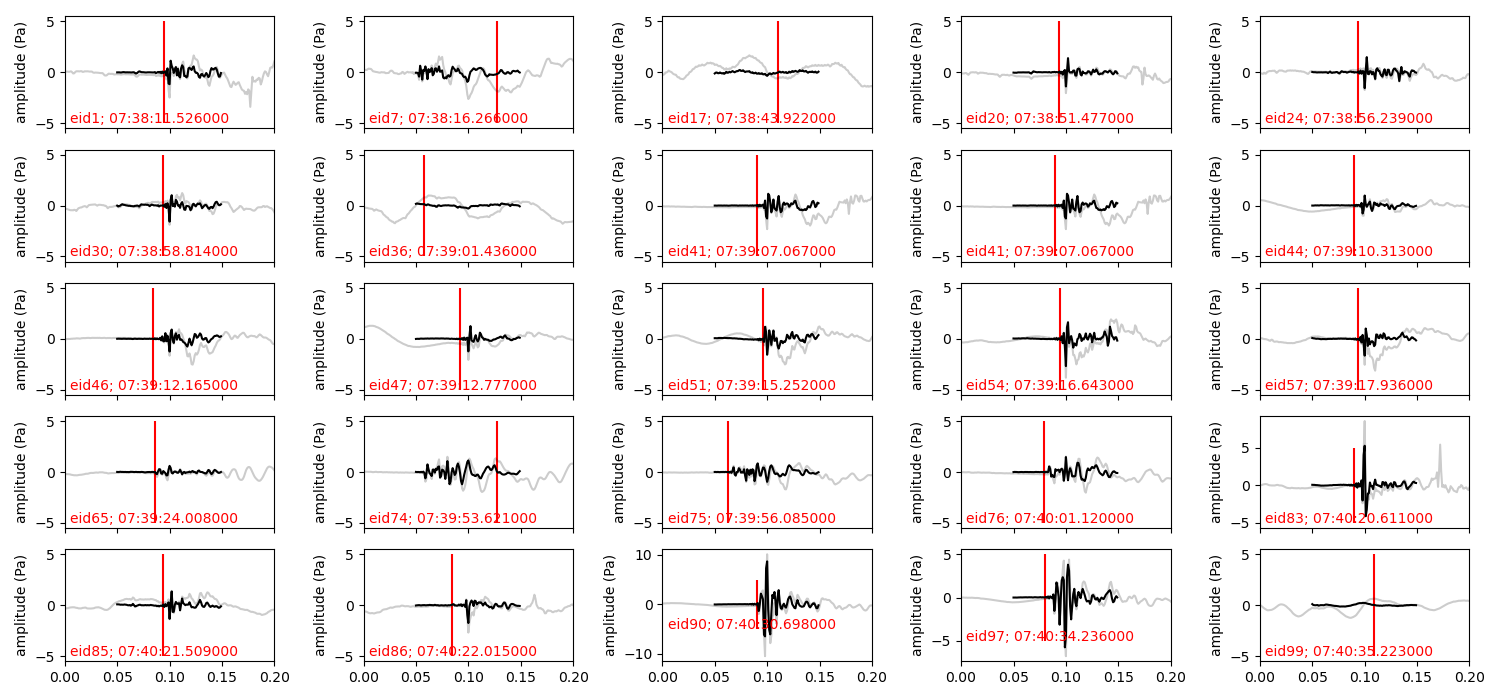

In [5]:
# fig, ax = plt.subplots(5, 1, figsize=(15, 7), sharex=True)
fig, ax = plt.subplots(5, 5, figsize=(15, 7), sharex=True)
ax = ax.flatten()

def aic_ppick(event_id, hydrophone, ax):
    firstcut = 50
    lastcut = 150
    
    ax.set_xlim(0, 0.2)
    
    event_raw = iet.get_event_window_raw(iet.df['event_times (abs)'].iloc[event_id], hydrophone=hydrophone)
    ax.plot(event_raw.times(), event_raw.data, color='black', alpha=0.2)
    event_raw.detrend('demean')
    event_raw.filter(type='highpass', freq=100, corners=1, zerophase=False)

    t = event_raw.times()[firstcut:lastcut]
    data = event_raw.data[firstcut:lastcut]
    
    aic = trigger.aic_simple(data)
    aic_arrival = t[aic.argmin()]
    # print(t)
    
    # ax.plot(t, event_raw.data, color='black')
    ax.plot(t, data, color='black')
    ax.set_ylabel('amplitude (Pa)')
    # ax2 = ax.twinx()
    # ax2.plot(t, aic, color='cyan', zorder=0)
    # ax2.set_ylabel('AIC', color='cyan', fontsize=15)
    ax.vlines(x=aic_arrival, ymin=-5, ymax=5, color='red', label='raw waveform aic')
    
# events = [44, 47, 52, 78, 96]
# events = [90, 91, 92, 93, 94]
events = np.random.randint(0, 100, 25)
events = sorted(events)
for n, e in enumerate(events):
    aic_ppick(e, 'h3', ax[n])
    
    t = str(iet.df['event_times'].iloc[e]).split()[1].split('+')[0]
    s = 'eid{eid}; {t}'.format(eid=e, t=t)
    ax[n].text(s=s, x=0.005, y=-5, color='red')

fig.tight_layout()

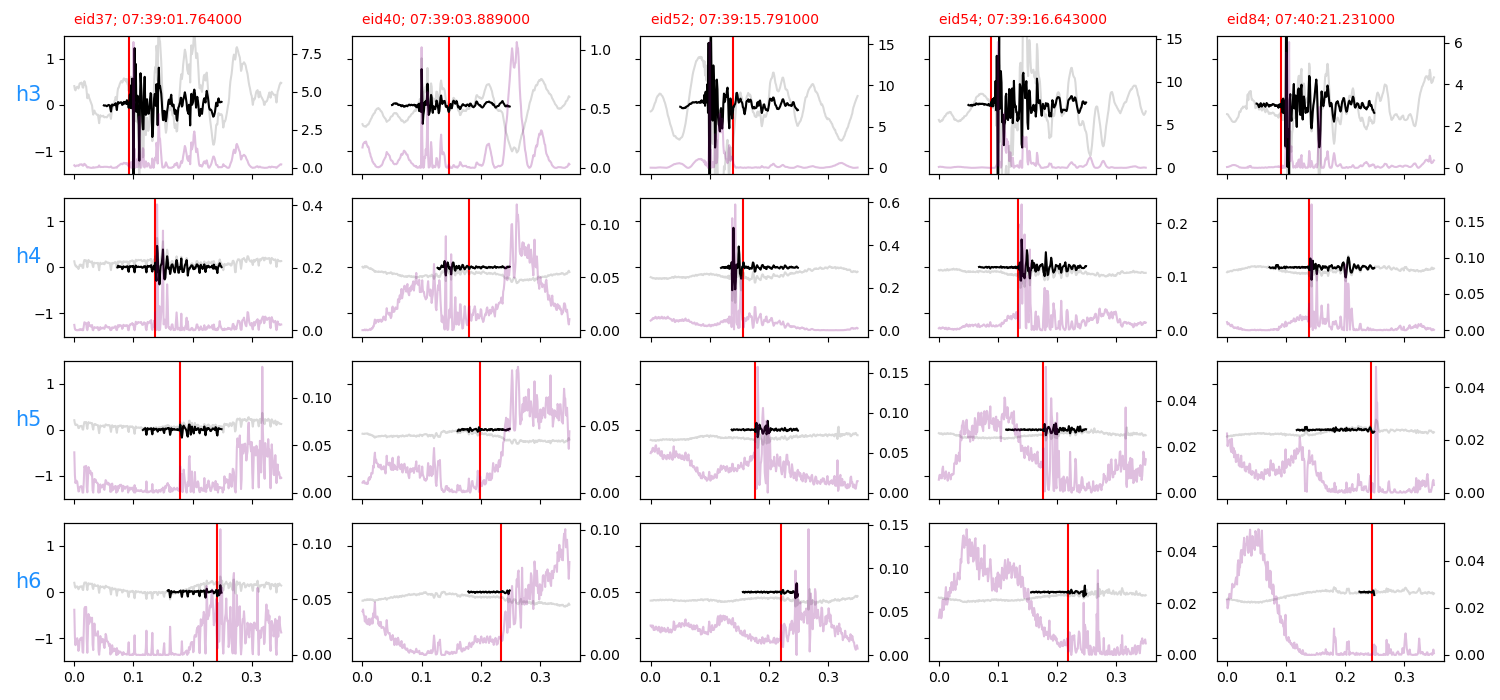

In [6]:
fig, ax = plt.subplots(4, 5, figsize=(15, 7), sharex=True, sharey=True)

# ax = ax.flatten()
# print(ax.shape)


def aic_ppick(times, data, fc, lc):
    """
    uses aic picker to find arrival time
    
    fc and lc tune the input data to control stuff
    """
    firstcut = fc
    lastcut = lc

    t = times[firstcut:lastcut]
    data = data[firstcut:lastcut]
    
    aic = trigger.aic_simple(data)
    aic_arrival = t[aic.argmin()]
    return aic_arrival, aic


events = np.random.randint(0, 100, 5)
events = sorted(events)

hydrophones = ['h3', 'h4', 'h5', 'h6']

for axcol, e in enumerate(events):
    fc = 50
    lc = 250
    
    t = str(iet.df['event_times'].iloc[e]).split()[1].split('+')[0]
    s = 'eid{eid}; {t}'.format(eid=e, t=t)   
    ax[0, axcol].text(s=s, x=0, y=1.75, color='red')
    
    for axrow, h in enumerate(hydrophones):
        ax[axrow, 0].set_ylabel(h, rotation=0, fontsize=15, color='dodgerblue')
        
        event_raw = iet.get_event_window_raw(iet.df['event_times (abs)'].iloc[e], hydrophone=h)
        ax[axrow, axcol].plot(event_raw.times(), event_raw.data, color='black', alpha=0.15)
        
        ax2 = ax[axrow, axcol].twinx()
        ax2.plot(event_raw.times(), event_raw.data**2, color='purple', alpha=0.25)

        event_raw.filter(type='highpass', freq=50, corners=1, zerophase=True)
        
        aic_arrival, aic = aic_ppick(times=event_raw.times(), data=event_raw.data, fc=fc, lc=lc)
        ax[axrow, axcol].vlines(aic_arrival, -2.5, 2.5, color='red')
        
        t = event_raw.times()[fc:lc]
        d = event_raw.data[fc:lc]
        ax[axrow, axcol].plot(t, d, color='black')

        
        fc = fc + aic.argmin() - 20

    
ax[axrow, axcol].set_ylim(-1.5, 1.5)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

working_event = 75
non_working_event = 50

event_initial_time = iet.df['event_times (abs)'].iloc[50]
event_raw = iet.get_event_window_raw(event_initial_time, hydrophone='h3')
spec, freq, time = signal_processing.spectrogram(event_raw.data, samp_rate=1000)
ax.pcolormesh(time, freq, spec, cmap='Oranges')
ax2 = ax.twinx()
ax2.plot(event_raw.times(), event_raw.data, color='black', alpha=0.25)

# start_window_edge = -0.1
# end_window_edge = 0.25
ax.vlines(0.1, ymin=0, ymax=500, color='red', linewidth=4)
ax.text(s='initial arrival time', x=0.08, y=-10, color='red', fontsize=15,)

event_raw.filter(type='highpass', freq=100, zerophase=False, corners=1)
ax2.plot(event_raw.times(), event_raw.data, color='black')

aic_arrival, aic = aic_ppick(event_raw.times(), event_raw.data, fc=0, lc=-1)
ax.vlines(aic_arrival, ymin=0, ymax=500, color='dodgerblue', linewidth=4)
ax.text(s='aic arrival time', x=aic_arrival-0.05, y=-20, color='dodgerblue', fontsize=15,)

ax3 = ax2.twinx()
ax3.plot(event_raw.times(), aic)

/tmp/ipykernel_10326/3080352457.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(time, freq, spec, cmap='Oranges')


ValueError: x and y must have same first dimension, but have shapes (351,) and (350,)

In [ ]:
# fig, ax = plt.subplots(4, 5, figsize=(15, 7), sharex=True)
# ax[0,3].plot([1,2,3], [3,2,1], color='red')
